# MathWriting Dataset

This notebook contains code snippets showing how to read data from the MathWriting dataset, and do some minimal processing.

Licensed under the Apache License, Version 2.0


In [1]:
import dataclasses
import json
import os
import pprint
import re

import numpy as np
import matplotlib.pyplot as pl
import matplotlib.patches as mpl_patches

from xml.etree import ElementTree

## Download

Download the data and unpack it.


In [2]:
# !wget -nc https://storage.googleapis.com/mathwriting_data/mathwriting-2024-excerpt.tgz
# !tar zxf mathwriting-2024-excerpt.tgz
# !ls mathwriting-2024-excerpt

MATHWRITING_ROOT_DIR='./mathwriting-2024'

In [3]:
# To use the full dataset, uncomment and run this cell instead of the one above.
#!wget -nc https://storage.googleapis.com/mathwriting_data/mathwriting-2024.tgz
#!tar zxf mathwriting-2024.tgz
#!ls mathwriting-2024
#MATHWRITING_ROOT_DIR='mathwriting-2024'

## Reading InkML files

All inks are provided in InkML format. The code below shows how to read the specific structure used by MathWriting.

In [3]:
@dataclasses.dataclass
class Ink:
  """Represents a single ink, as read from an InkML file."""
  # Every stroke in the ink.
  # Each stroke array has shape (3, number of points), where the first
  # dimensions are (x, y, timestamp), in that order.
  strokes: list[np.ndarray]
  # Metadata present in the InkML.
  annotations: dict[str, str]


def read_inkml_file(filename: str) -> Ink:
  """Simple reader for MathWriting's InkML files."""
  with open(filename, "r") as f:
    root = ElementTree.fromstring(f.read())

  strokes = []
  annotations = {}

  for element in root:
    tag_name = element.tag.removeprefix('{http://www.w3.org/2003/InkML}')
    if tag_name == 'annotation':
      annotations[element.attrib.get('type')] = element.text

    elif tag_name == 'trace':
      points = element.text.split(',')
      stroke_x, stroke_y, stroke_t = [], [], []
      for point in points:
        x, y, t = point.split(' ')
        stroke_x.append(float(x))
        stroke_y.append(float(y))
        stroke_t.append(float(t))
      strokes.append(np.array((stroke_x, stroke_y, stroke_t)))

  return Ink(strokes=strokes, annotations=annotations)


def display_ink(
    ink: Ink,
    *,
    figsize: tuple[int, int]=(15, 10),
    linewidth: int=2,
    color=None):
  """Simple display for a single ink."""
  pl.figure(figsize=figsize)
  for stroke in ink.strokes:
    pl.plot(stroke[0], stroke[1], linewidth=linewidth, color=color)
    pl.title(
        f"{ink.annotations.get('sampleId', '')} -- "
        f"{ink.annotations.get('splitTagOriginal', '')} -- "
        f"{ink.annotations.get('normalizedLabel', ink.annotations['label'])}"
    )
  pl.gca().invert_yaxis()
  pl.gca().axis('equal')

{'inkCreationMethod': 'human',
 'label': '\\binom{9}{4}',
 'normalizedLabel': '(\\begin{matrix}9\\\\ 4\\end{matrix})',
 'sampleId': '0000fe986018f92a',
 'splitTagOriginal': 'train'}


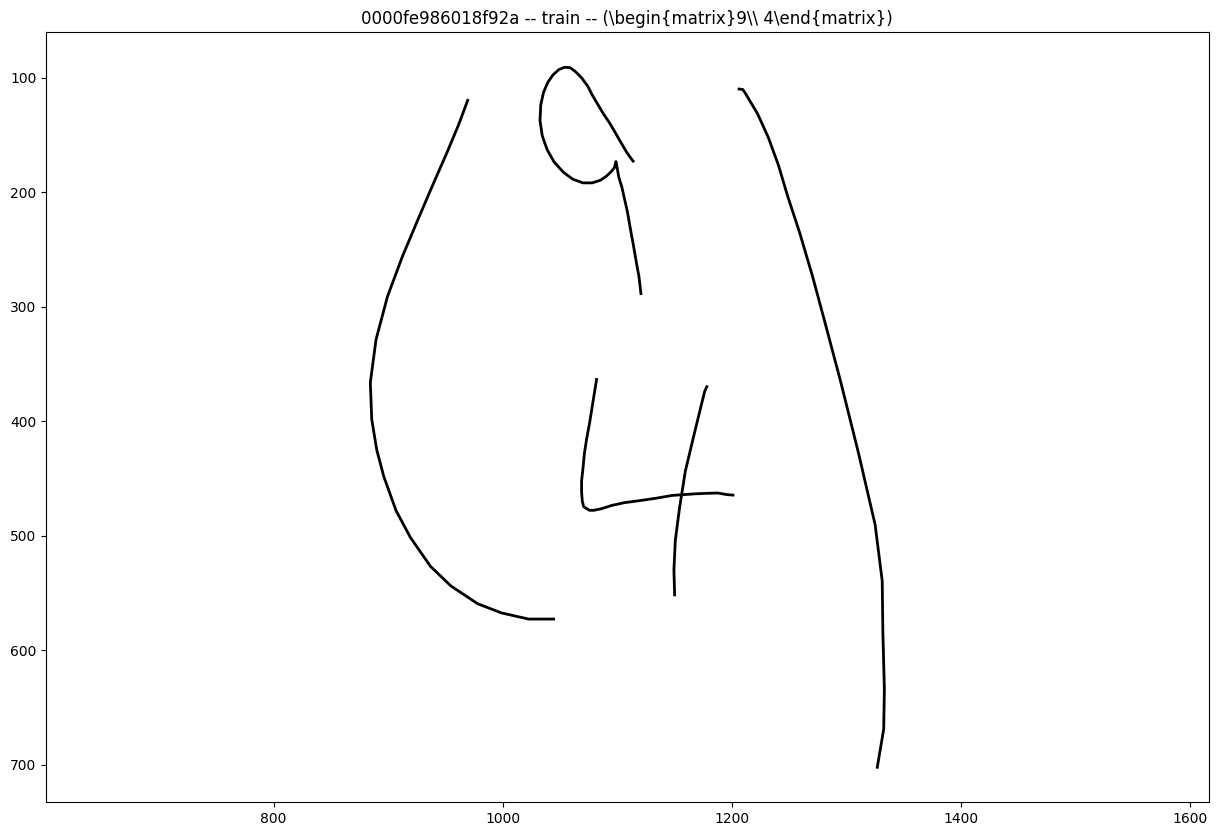

In [4]:
ink = read_inkml_file(os.path.join(MATHWRITING_ROOT_DIR, 'train', '0000fe986018f92a.inkml'))
pprint.pprint(ink.annotations)
display_ink(ink, color='black')

## Reading Bounding Box Files

These files contain bounding boxes with the symbol that should be displayed in it, plus the LaTeX string for the overall expression. The format used is JSONL: each line in the file is a separate JSON object containing all the bounding boxes for a single mathematical expression.

The code below shows how to turn each of these lines into a Python class.

In [6]:
@dataclasses.dataclass
class BoundingBox:
  """A bounding box for a single symbol."""
  # The symbol that should appear in the bounding box, in LaTeX notation.
  token: str
  # Definition of the bounding box.
  x_min: float
  y_min: float
  x_max: float
  y_max: float


@dataclasses.dataclass
class BoundingBoxes:
  """A set of bounding boxes for a complete mathematical expression."""
  # The complete (raw) LaTeX string.
  label: str
  # A normalized version of `label`.
  normalized_label: str|None
  # Bounding boxes for all symbols in the expression, in no particular order.
  bboxes: list[BoundingBox]


def read_bbox_file(filename: str, *, index: int=0) -> BoundingBoxes:
  """Reads a single bounding box from the input file."""
  with open(filename, "r") as f:
    for n, line in enumerate(f):
      if n < index:
        continue

      bboxes = json.loads(line)

      symbol_bboxes = []
      for bbox in bboxes['bboxes']:
        symbol_bboxes.append(BoundingBox(
            token=bbox['token'],
            x_min=bbox['xMin'],
            y_min=bbox['yMin'],
            x_max=bbox['xMax'],
            y_max=bbox['yMax']))

      return BoundingBoxes(
              label=bboxes['label'],
              normalized_label=bboxes.get('normalizedLabel', None),
              bboxes = symbol_bboxes)


def display_bboxes(bboxes: BoundingBoxes, *, figsize: tuple[int, int]=(15, 10)):
  """Displays a set of bounding boxes for debugging purposes."""
  fig = pl.figure(figsize=figsize)
  ax = fig.gca()
  x_min = float('inf')
  y_min = float('inf')
  x_max = -float('inf')
  y_max = -float('inf')
  for bbox in bboxes.bboxes:
    x_min = min(x_min, bbox.x_min)
    y_min = min(y_min, bbox.y_min)
    x_max = max(x_max, bbox.x_max)
    y_max = max(y_max, bbox.y_max)

    ax.add_patch(
        mpl_patches.Polygon(
            ((bbox.x_min,bbox.y_min),
            (bbox.x_min,bbox.y_max),
            (bbox.x_max,bbox.y_max),
            (bbox.x_max, bbox.y_min)),
            closed=True,
            facecolor='none',
            edgecolor='darkblue',
            linewidth=2))

  width = x_max - x_min
  height = y_max - y_min

  # We put the text in one go at the end to be able to scale it properly.
  for bbox in bboxes.bboxes:
    box_width = bbox.x_max - bbox.x_min
    box_height = bbox.y_max - bbox.y_min
    if bbox.token != r'\frac':
      ax.text(bbox.x_min+box_width/2,
              bbox.y_min+box_height/2,
              bbox.token,
              verticalalignment='center',
              horizontalalignment='center',
              fontsize=100000 / max(width, height))

  margin_ratio = 0.1
  ax.set_xlim(x_min-margin_ratio*width, x_max+margin_ratio*width)
  ax.set_ylim(y_max+margin_ratio*height, y_min-margin_ratio*height)
  pl.title(bboxes.normalized_label or bboxes.label)


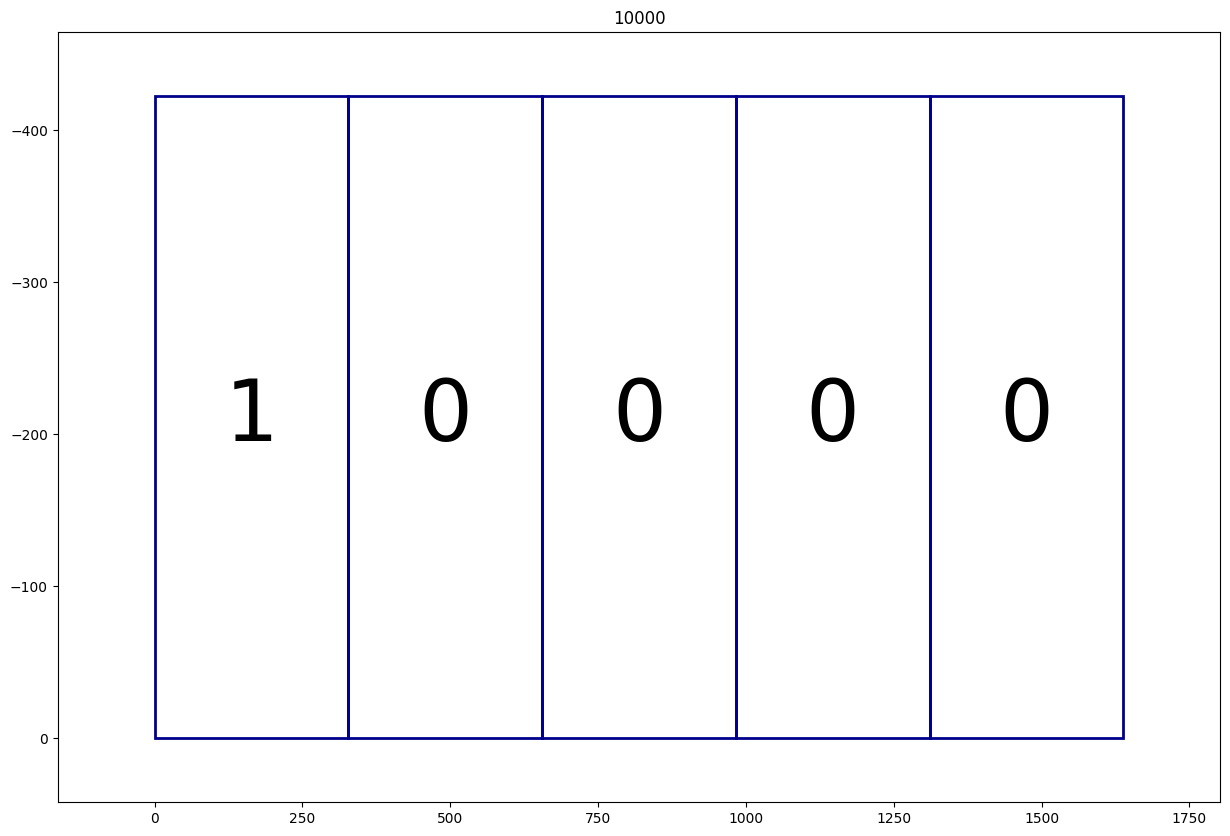

In [7]:
bboxes = read_bbox_file(
    os.path.join(MATHWRITING_ROOT_DIR, 'synthetic-bboxes.jsonl'),
    index=2)
display_bboxes(bboxes)

## Extracting Individual Symbols

For the purpose of synthesizing inks from bounding boxes, isolated symbols are provided as inks. These were extracted from inks from the training set, and MathWriting contains all the information necessary to recompute this extraction.
The code below shows how to do it.


In [8]:
@dataclasses.dataclass
class InkPart:
  """A pointer to a part of an ink corresponding to a single symbol."""
  # Which sample the symbol is from. Ex: '00016221aae38d32'
  source_sample_id: str
  # Which symbol it is. Ex: '\sum'
  label: str
  # Indices of strokes in the source ink that cover the symbol.
  stroke_indices: list[int]


def read_symbols_file(filename: str) -> list[InkPart]:
  """Reads all the symbol definitions."""
  symbols = []
  with open(filename, "r") as f:
    for line in f:
      symbol_json = json.loads(line)
      symbols.append(InkPart(
          source_sample_id=symbol_json['sourceSampleId'],
          label=symbol_json['label'],
          stroke_indices=symbol_json['strokeIndices']))
  return symbols


def get_symbol_ink(symbol: InkPart) -> Ink:
  """Computes the actual ink from an InkPart object."""
  ink = read_inkml_file(
      os.path.join(MATHWRITING_ROOT_DIR, "train", f"{symbol.source_sample_id}.inkml"))
  strokes = [ink.strokes[i] for i in symbol.stroke_indices]
  return Ink(
      strokes=strokes,
      annotations={
          'label': symbol.label,
          'splitTagOriginal': ink.annotations['splitTagOriginal']})

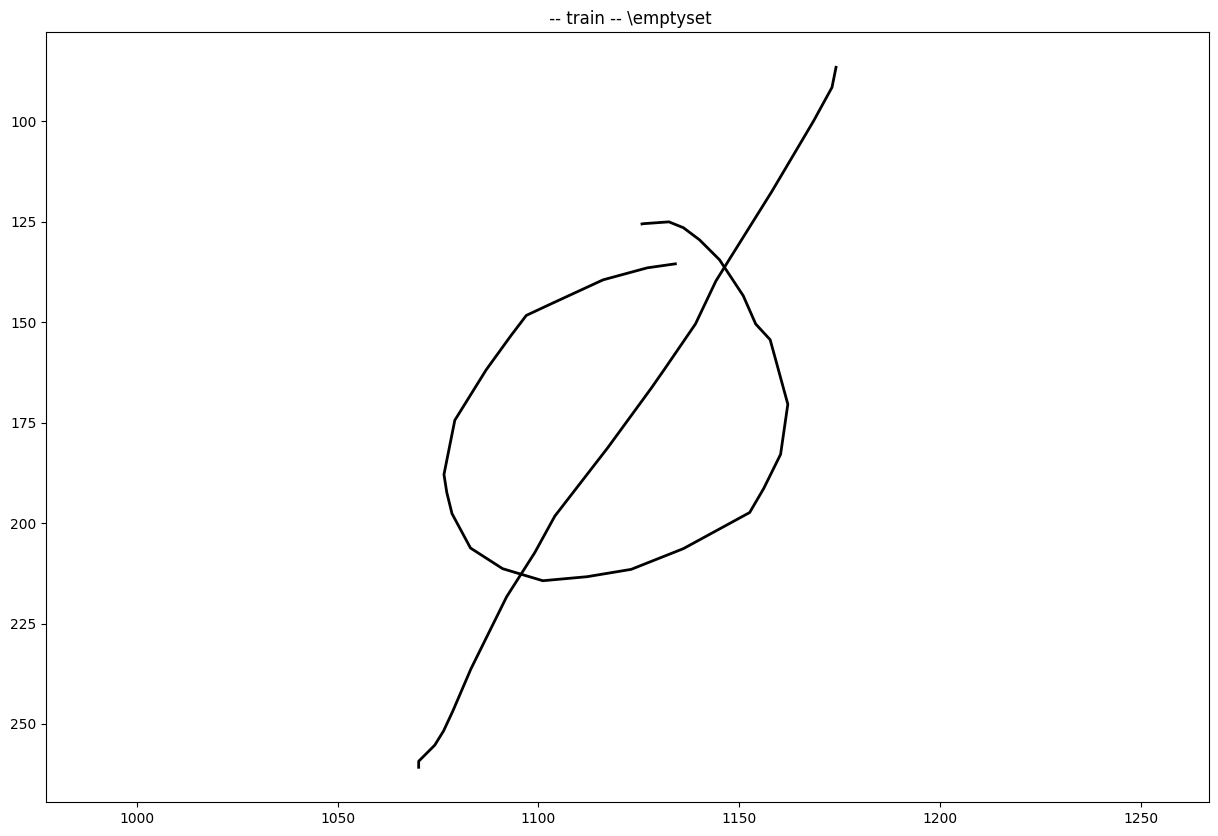

In [9]:
# Extract one isolated symbol and display it.
symbols = read_symbols_file(os.path.join(MATHWRITING_ROOT_DIR, 'symbols.jsonl'))
symbol_ink = get_symbol_ink(symbols[3902])
display_ink(symbol_ink, color='black')

## Ink Rasterization

This shows how to use Cairo for high-quality rendering of inks.

In [10]:
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo

'apt-get' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


In [11]:
import cairo
import math
import PIL
import PIL.Image


def cairo_to_pil(surface: cairo.ImageSurface) -> PIL.Image.Image:
  """Converts a ARGB Cairo surface into an RGB PIL image."""
  size = (surface.get_width(), surface.get_height())
  stride = surface.get_stride()
  with surface.get_data() as memory:
    return PIL.Image.frombuffer(
        'RGB', size, memory.tobytes(), 'raw', 'BGRX', stride
    )


def render_ink(
    ink: Ink,
    *,
    margin: int = 10,
    stroke_width: float = 1.5,
    stroke_color: tuple[float, float, float] = (0.0, 0.0, 0.0),
    background_color: tuple[float, float, float] = (1.0, 1.0, 1.0),
) -> PIL.Image.Image:
  """Renders an ink as a PIL image using Cairo.

  The image size is chosen to fit the entire ink while having one pixel per
  InkML unit.

  Args:
    margin: size of the blank margin around the image (pixels)
    stroke_width: width of each stroke (pixels)
    stroke_color: color to paint the strokes with
    background_color: color to fill the background with

  Returns:
    Rendered ink, as a PIL image.
  """

  # Compute transformation to fit the ink in the image.
  xmin, ymin = np.vstack([stroke[:2].min(axis=1) for stroke in ink.strokes]).min(axis=0)
  xmax, ymax = np.vstack([stroke[:2].max(axis=1) for stroke in ink.strokes]).max(axis=0)
  width = int(xmax - xmin + 2*margin)
  height = int(ymax - ymin + 2*margin)

  shift_x = - xmin + margin
  shift_y = - ymin + margin

  def apply_transform(ink_x: float, ink_y: float):
    return ink_x + shift_x, ink_y + shift_y

  # Create the canvas with the background color
  surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, width, height)
  ctx = cairo.Context(surface)
  ctx.set_source_rgb(*background_color)
  ctx.paint()

  # Set pen parameters
  ctx.set_source_rgb(*stroke_color)
  ctx.set_line_width(stroke_width)
  ctx.set_line_cap(cairo.LineCap.ROUND)
  ctx.set_line_join(cairo.LineJoin.ROUND)

  for stroke in ink.strokes:
    if len(stroke[0]) == 1:
      # For isolated points we just draw a filled disk with a diameter equal
      # to the line width.
      x, y = apply_transform(stroke[0, 0], stroke[1, 0])
      ctx.arc(x, y, stroke_width / 2, 0, 2 * math.pi)
      ctx.fill()

    else:
      ctx.move_to(*apply_transform(stroke[0,0], stroke[1,0]))

      for ink_x, ink_y in stroke[:2, 1:].T:
        ctx.line_to(*apply_transform(ink_x, ink_y))
      ctx.stroke()

  return cairo_to_pil(surface)

ink = read_inkml_file(os.path.join(MATHWRITING_ROOT_DIR, 'train', '0668dd347d600906.inkml'))

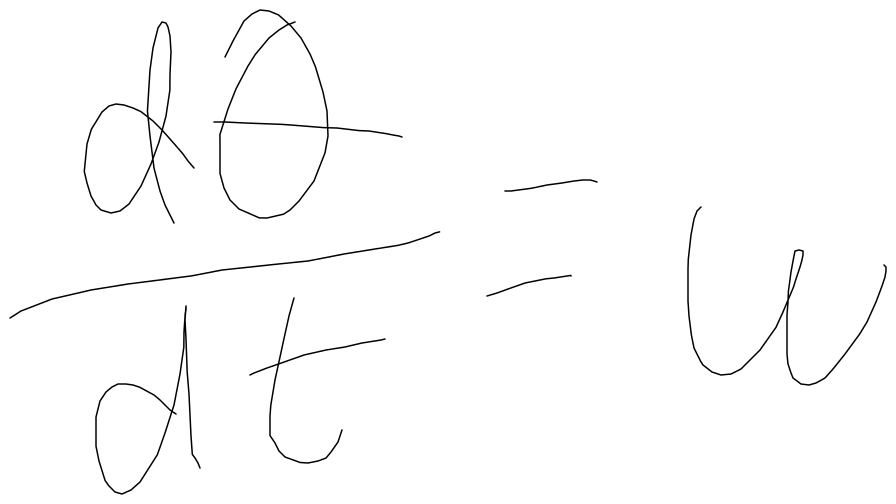

In [12]:
render_ink(ink)

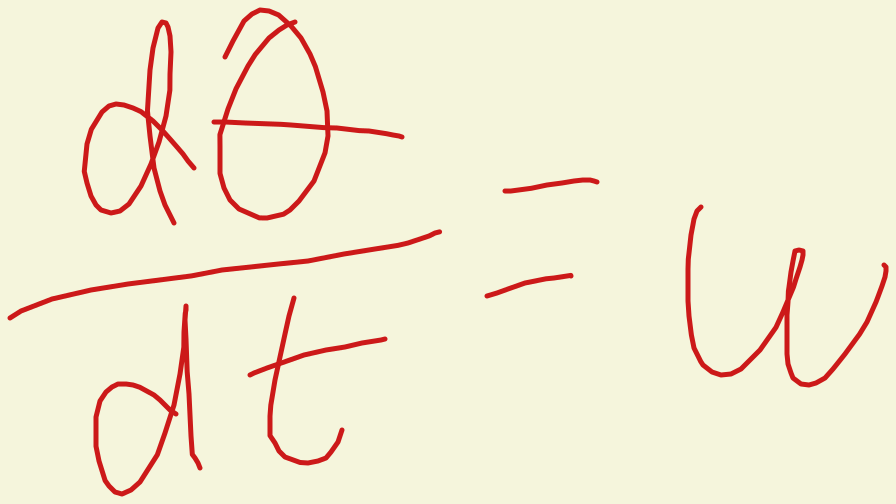

In [13]:
render_ink(
    ink,
    stroke_width=5.0,
    stroke_color=(.8, .1, .1),
    background_color=(.96, .96, .86),
  )

## Model Evaluation

A few functions to compute the character error rate for model performance evaluation.

### Tokenizer

Function to split a LaTeX expressions into tokens. These tokens can be used for model training or model evaluation.

In [14]:
_COMMAND_RE = re.compile(r'\\(mathbb{[a-zA-Z]}|begin{[a-z]+}|end{[a-z]+}|operatorname\*|[a-zA-Z]+|.)')


def tokenize_expression(s: str) -> list[str]:
  r"""Transform a Latex math string into a list of tokens.

  Tokens are strings that are meaningful in the context of Latex
  e.g. '1', r'\alpha', r'\frac'.

  Args:
    s: unicode input string (ex: r"\frac{1}{2}")

  Returns:
    tokens: list of tokens as unicode strings.
  """
  tokens = []
  while s:
    if s[0] == '\\':
      tokens.append(_COMMAND_RE.match(s).group(0))
    else:
      tokens.append(s[0])

    s = s[len(tokens[-1]) :]

  return tokens


# Example
print(tokenize_expression(r'\frac{\alpha}{2}\begin{matrix}1&0\\0&1\end{matrix}\not\in\mathbb{R}'))

['\\frac', '{', '\\alpha', '}', '{', '2', '}', '\\begin{matrix}', '1', '&', '0', '\\\\', '0', '&', '1', '\\end{matrix}', '\\not', '\\in', '\\mathbb{R}']


### CER Computation

Computation of the Character Error Rate.

In [ ]:
!pip install jiwer
import jiwer

In [ ]:
def compute_cer(truth_and_output: list[tuple[str, str]]):
  """Computes CER given pairs of ground truth and model output."""
  class TokenizeTransform(jiwer.transforms.AbstractTransform):
    def process_string(self, s: str):
      return tokenize_expression(r'{}'.format(s))

    def process_list(self, tokens: list[str]):
      return [self.process_string(token) for token in tokens]

  ground_truth, model_output = zip(*truth_and_output)

  return jiwer.cer(truth=list(ground_truth),
            hypothesis=list(model_output),
            reference_transform=TokenizeTransform(),
            hypothesis_transform=TokenizeTransform(),
      )

In [ ]:
# Test data to run compute_cer().
# The first element is the model prediction, the second the ground truth.
examples = [
    (r'\sqrt{2}', r'\sqrt{2}'),  # 0 mistakes, 4 tokens
    (r'\frac{1}{2}', r'\frac{i}{2}'),  # 1 mistake, 7 tokens
    (r'\alpha^{2}', 'a^{2}'),  # 1 mistake, 5 tokens
    ('abc', 'def'),  # 3 mistakes, 3 tokens
]

# 5 mistakes for 19 tokens: 26.3% error rate.
print(f"{compute_cer(examples)*100:.1f} %")